In [17]:
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel,DPMSolverMultistepScheduler
from diffusers import StableDiffusionPipeline
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [18]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler", algorithm_type="sde-dpmsolver++")

vae.to(device)
unet.to(device)
text_encoder.to(device)


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

## Text to image Pipeline

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

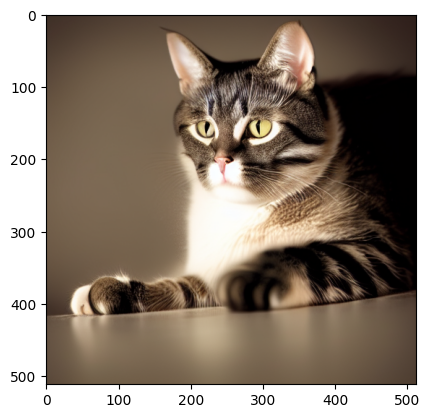

In [3]:
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

pipeline.to(device)

prompt = "A cat"

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(device)

images = pipeline(
        prompt=prompt,
        negative_prompt="",
        latents=latents,
        num_inference_steps=50,
        guidance_scale=7.5,
        generator = generator,
        
    )

plt.imshow(images.images[0])
plt.show()



## Image to Image Pipeline

In [19]:
from diffusers import StableDiffusionImg2ImgPipeline

img2img_pipe = StableDiffusionImg2ImgPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


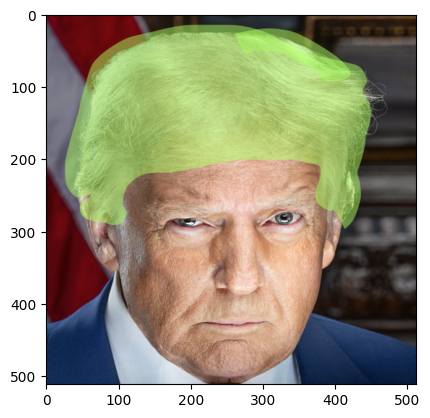

In [20]:
img2img_pipe.to(device)

image = Image.open("dt_hair.png").resize((512,512)).convert("RGB")

plt.imshow(image)
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

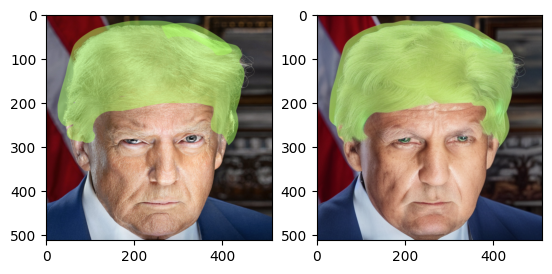

In [22]:
gen_image = img2img_pipe(prompt="a man with neon green hair",
                            image=image, 
                            strength=0.2, 
                            guidance_scale=7.5, 
                            num_inference_steps=50,
                            ).images[0]

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(gen_image)
# clear_output(wait=True)
plt.show()

## Inpainting Pipeline

In [8]:
from diffusers import StableDiffusionInpaintPipeline

inpaint_pipe = StableDiffusionInpaintPipeline.from_pipe(img2img_pipe)

inpaint_pipe.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.35.2",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

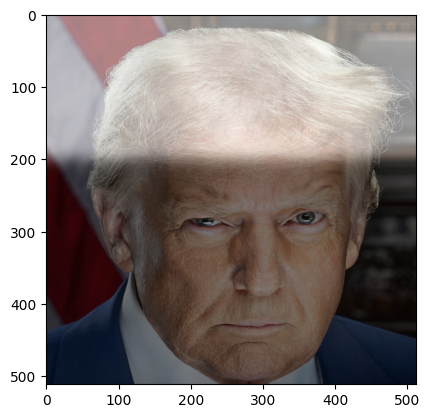

In [13]:
from scipy.ndimage import gaussian_filter

ref_image = Image.open('dt.png').crop((300,200,2200,2300)).resize((512,512)).convert('RGB')

mask = np.zeros((512,512), dtype=np.float32)
mask[0:200, :] = 1.0
mask = gaussian_filter(mask, sigma=10)
mask=Image.fromarray((mask * 255).astype(np.uint8))

# plot the mask and inv mask
plt.imshow(ref_image)
plt.imshow(mask,cmap='grey',alpha=0.5)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

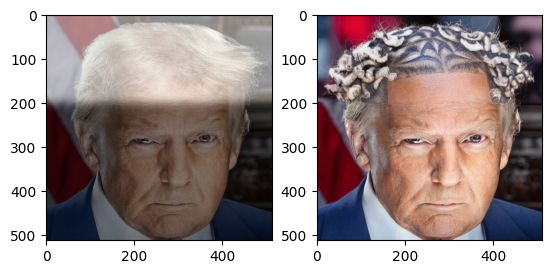

In [23]:
gen_image = inpaint_pipe(prompt="black dark hair, jay z",
                            image=ref_image, 
                            mask_image=mask,
                            strength=0.6, 
                            guidance_scale=7.5, 
                            num_inference_steps=50,
                            ).images[0]

plt.subplot(1,2,1)
plt.imshow(ref_image)
plt.imshow(mask,cmap='grey',alpha=0.5)
plt.subplot(1,2,2)
plt.imshow(gen_image)
# clear_output(wait=True)
plt.show()